In [ ]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab Notebooks/'       # path to your project on Drive



drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)


In [ ]:
GIT_USERNAME = "ahhuang007" # replace with yours
GIT_TOKEN = os.environ['git_key_wsb']           # definitely replace with yours
GIT_REPOSITORY = "wallstreetbets"      # ...nah


In [16]:
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/wallstreetbets’: File exists
/content/drive/My Drive/Colab Notebooks/wallstreetbets


In [32]:
#GIT_PATH = "https://GIT_TOKEN@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"
!git clone "https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git"
#!rsync -aP --exclude=data/ "{PROJECT_PATH}"/*  ./

Cloning into 'wallstreetbets'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 362 (delta 202), reused 293 (delta 133), pack-reused 0
Receiving objects: 100% (362/362), 3.16 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [3]:
%cd wallstreetbets

[Errno 2] No such file or directory: 'wallstreetbets'
/content


In [19]:
!mv ./wallstreetbets/* "{PROJECT_PATH}"

In [31]:
!rm -rf ./wallstreetbets

Pulling data from Github

In [2]:
%cd drive/My Drive/Colab Notebooks/wallstreetbets

/content/drive/My Drive/Colab Notebooks/wallstreetbets


In [6]:
!git pull origin

remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 23 (delta 13), reused 23 (delta 13), pack-reused 0
Unpacking objects: 100% (23/23), done.
From https://github.com/ahhuang007/wallstreetbets
   1448915..5f8a895  main       -> origin/main
Updating 1448915..5f8a895
Fast-forward
 .../envs/__pycache__/val_env.cpython-37.pyc        | Bin 6680 -> 7152 bytes
 .../envs/__pycache__/wsb_env.cpython-37.pyc        | Bin 6844 -> 7316 bytes
 gym-wsb/gym_wsb/envs/val_env.py                    |  18 +++++++++++-------
 gym-wsb/gym_wsb/envs/wsb_env.py                    |  19 +++++++++++--------
 main.py                                            |  21 +++++++++++++++++----
 models/trained_models/trained_model_ppo_v23.zip    | Bin 0 -> 147868 bytes
 models/trained_models/trained_model_ppo_v24.zip    | Bin 0 -> 146447 bytes
 validation.py                                      |  16 ++++++++++++++--
 8 files c

Adding stuff to Github

In [3]:
!git add .

In [4]:
!git config --global user.email "ahhuang007@gmail.com"
!git config --global user.name "ahhuang007"

In [5]:
!git commit -m "added version detection, tried a bigger model that didn't pan out - going to try DCA strategy"

[main 25773c8] added version detection, tried a bigger model that didn't pan out - going to try DCA strategy
 2 files changed, 1 insertion(+), 1 deletion(-)
 rewrite colab_wsb.ipynb (93%)
 create mode 100644 nn_stuff/models/model_4.pth


In [43]:
!git remote set-url origin https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git

In [6]:
!git push origin

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 1.51 MiB | 4.21 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ahhuang007/wallstreetbets.git
   5f8a895..25773c8  main -> main


In [45]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   colab_wsb.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


Actual Code Below

The reason for this Colab file is to explore the viability of using a NN instead of an RL policy - in theory, we already know a basic optimal policy (buy before it increases, sell before it decreases), we just need to figure out if it will increase/decrease beforehand, which a NN can maybe do.

In [7]:
import pandas as pd

In [3]:
%cd drive/MyDrive/Colab Notebooks/wallstreetbets

/content/drive/MyDrive/Colab Notebooks/wallstreetbets


In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class wsb_dataset(Dataset):
  """class for formatting training data"""

  def __init__(self, df, labels):
    self.df = df
    self.labels = labels
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    sample = self.df.iloc[idx, :]
    sample = np.array([sample])
    sample = sample.astype('float')#.reshape(-1, 2)
    label = self.labels[idx]
    return sample, label

In [9]:
#Gathering data, formatting it for NN
from sklearn.preprocessing import MinMaxScaler

dfs = []
training_datas = []
cryptos = ['AAVE', 'ADA', 'ALGO', 'ATOM', 
           'AVAX', 'BCH', 'BTC', 'DOT', 
           'ETH', 'LINK', 'LRC', 'LTC', 
           'MANA', 'MATIC', 'SOL', 'UNI']
cryptos = ['BTC']
for c in cryptos:
    df = pd.read_csv('./data/' + c + '_data.csv')
    '''I think we'll do a similar plan to my source idea.
    5 months for training, 2 months for validation/tuning, 5 months for testing
    '''
    #dfs.append(df[38:175200].reset_index(drop = True))
    #Splitting data into training/validation/test
    
    df = df.drop(['timestamp', 'Unnamed: 0'], axis = 1)
    df = df[38:]

    #Normalizing data
    scaler = MinMaxScaler()
    df = pd.DataFrame(data = scaler.fit_transform(df))
    labels = df[3][1:].reset_index(drop = True)
    training = wsb_dataset(df[:175200].reset_index(drop = True), labels[:175200].reset_index(drop = True))
    validation = wsb_dataset(df[175200:282600].reset_index(drop = True), labels[175200:282600].reset_index(drop = True))
    testing = wsb_dataset(df[262800:-1].reset_index(drop = True), labels[262800:].reset_index(drop = True))
    training_datas.append([training, validation, testing])

In [10]:
train_dataloader = DataLoader(training_datas[0][0], batch_size = 64)
valid_dataloader = DataLoader(training_datas[0][1], batch_size = 64)

In [11]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 8])
Shape of y: torch.Size([64]) torch.float64


In [12]:
##Create NN
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        #print(x)
        logits = self.linear_relu_stack(x)
        return logits


In [13]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [14]:
def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

In [15]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [16]:
##Train NN
import time
def train(dataloader, model, loss_fn, optimizer, accs):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred.squeeze(), y.float())
        #print(pred)
        #print(loss)
        #time.sleep(10)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            #print(loss)
            loss, current = loss.item(), batch * len(X)
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            accs.append(loss)
    return accs

In [ ]:
for X, y in train_dataloader:
  print(X[0])
  preds = model(X.float())
  print(preds)
  print(loss_fn(preds.squeeze(), y.float()))
  break

In [17]:
def test(dataloader, model, loss_fn, accs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred.squeeze(), y.float()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accs.append(test_loss)
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return accs

In [19]:
train_accs = []
test_accs = []

In [20]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    if t < 2:
        train_accs = train(train_dataloader, model, loss_fn, optimizer, train_accs)
        test_accs = test(valid_dataloader, model, loss_fn, test_accs)
    elif t >= 2 and test_accs[-1] < test_accs[-2]:
        train_accs = train(train_dataloader, model, loss_fn, optimizer, train_accs)
        test_accs = test(valid_dataloader, model, loss_fn, test_accs)
    else:
        pass
print("Done!")

Epoch 1
-------------------------------
loss: 0.001398  [    0/175200]
loss: 0.059836  [64000/175200]
loss: 0.005366  [128000/175200]
Test Error: 
 Avg loss: 0.150778 

Epoch 2
-------------------------------
loss: 0.325048  [    0/175200]
loss: 0.033356  [64000/175200]
loss: 0.003358  [128000/175200]
Test Error: 
 Avg loss: 0.119654 

Epoch 3
-------------------------------
loss: 0.260013  [    0/175200]
loss: 0.024538  [64000/175200]
loss: 0.002123  [128000/175200]
Test Error: 
 Avg loss: 0.087895 

Epoch 4
-------------------------------
loss: 0.193602  [    0/175200]
loss: 0.015563  [64000/175200]
loss: 0.001362  [128000/175200]
Test Error: 
 Avg loss: 0.060352 

Epoch 5
-------------------------------
loss: 0.135788  [    0/175200]
loss: 0.007900  [64000/175200]
loss: 0.000851  [128000/175200]
Test Error: 
 Avg loss: 0.038542 

Epoch 6
-------------------------------
loss: 0.088191  [    0/175200]
loss: 0.003622  [64000/175200]
loss: 0.000516  [128000/175200]
Test Error: 
 Avg los

In [22]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir('./nn_stuff/models') 
             if isfile(join('./nn_stuff/models', f))]
version = str(len(onlyfiles))

torch.save(model.state_dict(), "nn_stuff/models/model_" + version + ".pth")

Plotting data (pretty much just losses)

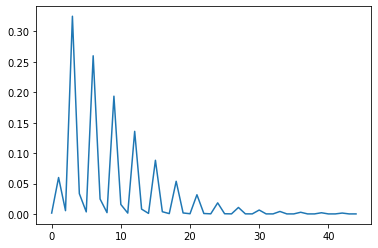

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_accs)
plt.show()

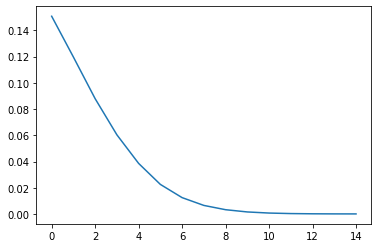

In [24]:
fig = plt.figure()
plt.plot(test_accs)
plt.show()

In [18]:
##Test model in testing data

#basic framework - for each timestep, we feed data into network to get prediction.
#If price will increase by enough, we buy/hold. If it will decrease, we sell/don't buy.

#Code for loading saved model
model = NeuralNetwork()
model.load_state_dict(torch.load("nn_stuff/models/model_4.pth"))

<All keys matched successfully>

In [19]:
testing_loader = DataLoader(training_datas[0][2], batch_size = 1)

In [20]:
for X, y in testing_loader:
  print(X)
  print(X[0])
  preds = model(X.float())
  print(preds)
  print(loss_fn(preds.squeeze(), y.float()))
  break

tensor([[[0.1198, 0.1089, 0.1229, 0.1207, 0.0054, 0.5827, 0.3511, 0.1440]]],
       dtype=torch.float64)
tensor([[0.1198, 0.1089, 0.1229, 0.1207, 0.0054, 0.5827, 0.3511, 0.1440]],
       dtype=torch.float64)
tensor([[0.1212]], grad_fn=<AddmmBackward0>)
tensor(3.1593e-07, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [21]:
#DCA approach - use max(10% of balance, $10) to buy, 10% of shares to sell
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        amount = 
        balance += amount * close
        shares -= amount
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        amount = max(0.1 * balance, 10)
        amount = min(balance, amount)
        shares += (amount / close)
        balance -= amount
        
    else:
        pass #No money to buy!
    return balance, shares

In [27]:
#naive approach - all-in trades with no fees
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        balance += shares * close
        shares = 0
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        shares += (balance / close)
        balance = 0
        
    else:
        pass
    return balance, shares

In [22]:
balance = 100
shares = 0
counter = 262800
orig_df = pd.read_csv('./data/BTC_data.csv')[262799:]
total = []
cur = orig_df.loc[262799, "close"]
for X, y in testing_loader:
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = model(X.float()).item()
    cur_norm = X[0][0][3].item()
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 270000: Balance is 34.3973986055136, shares is 0.0020380928836410362, total is 104.86446005740243
Timestep 280000: Balance is 0.0, shares is 0.0029272247861472076, total is 95.6913002538787
Timestep 290000: Balance is 0.0, shares is 0.0028976751331595517, total is 93.58548935687075
Timestep 300000: Balance is 0.0, shares is 0.0025352713513041394, total is 101.71473167633289
Timestep 310000: Balance is 101.76543148571085, shares is 0, total is 101.76543148571085
Timestep 320000: Balance is 0.0, shares is 0.002429575423817667, total is 112.82202388554133
Timestep 330000: Balance is 0.0, shares is 0.0023912439268965182, total is 108.33917992320833
Timestep 340000: Balance is 0.0, shares is 0.002364843572099897, total is 112.88315928938783
Timestep 350000: Balance is 0.0, shares is 0.002372923951646284, total is 112.96968890518596
Timestep 360000: Balance is 0.0, shares is 0.002316045688662217, total is 107.14057464345369
Timestep 370000: Balance is 0.0, shares is 0.00228962301623

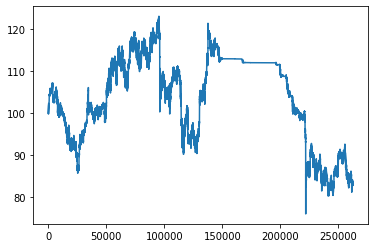

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(total)
plt.show()

In [ ]:
#Downloading file
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')